In [ ]:
!pip install gensim
!pip install bitermplus
!pip install tmplot
!pip install --upgrade gensim
!pip install pandas --upgrade
!pip uninstall pandas
!pip install pandas==1.1.5
!pip install pyLDAvis

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import re
import string
from itertools import combinations

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Nmf


import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import sklearn
from sklearn import decomposition
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text
import sklearn.feature_extraction
from sklearn.feature_extraction import DictVectorizer


from operator import itemgetter
from collections import Counter

from google.colab import drive
drive.mount('/drive')


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.corpus import gutenberg
#from nltk.tokenize import WhitespaceTokenizer, WordPunctTokenizer
from nltk.tokenize import WhitespaceTokenizer
from pprint import pprint
from nltk import word_tokenize, pos_tag
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('gutenberg')
nltk.download('stopwords')

import bitermplus as btm
import tmplot as tmp
import pickle as pkl
import warnings
warnings.filterwarnings('ignore')

import pyLDAvis.gensim_models

In [ ]:
stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_sm') 
nlp.disable_pipes('ner', 'parser')


In [71]:
df_jobs = pd.read_csv("/drive/My Drive/Colab Notebooks/master_ds.csv")
df_jobs = df_jobs.drop(columns = ['Name','Train','Valid','Test','Source'], axis =1)

In [72]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2147 entries, 0 to 2146
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Company      2146 non-null   object
 1   Salary       1299 non-null   object
 2   Location     2147 non-null   object
 3   Description  2142 non-null   object
dtypes: object(4)
memory usage: 67.2+ KB


In [73]:
# get the word count in each job description
df_jobs = df_jobs[df_jobs['Description'].notnull()]
df_jobs['word_count'] = df_jobs['Description'].map(lambda x: x.split()).str.len()

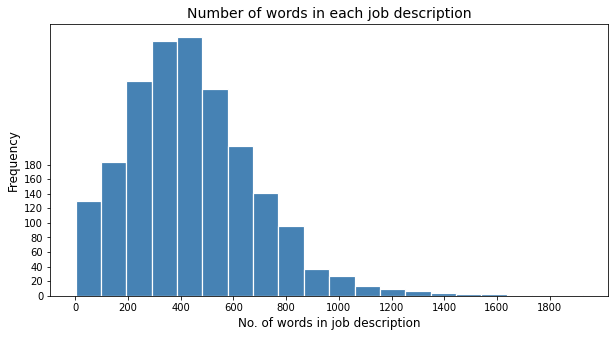

In [74]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    df_jobs['word_count'],
    bins=20,
    color='steelblue',
    edgecolor='white', 
    linewidth=1.2
)

plt.title('Number of words in each job description', fontsize=14)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('No. of words in job description', fontsize=12)
plt.yticks(np.arange(0, 200, 20))
plt.xticks(np.arange(0, 2000, 200))

plt.show()

In [75]:
# Keep only rows where job_descriptions are more than 50 words
df_jobs = df_jobs[df_jobs['word_count']>50]

In [76]:
#average word count in chapter 
display(df_jobs['word_count'].describe())

count    2075.000000
mean      456.053976
std       239.062902
min        51.000000
25%       284.000000
50%       428.000000
75%       591.000000
max      1926.000000
Name: word_count, dtype: float64

In [77]:
df_jobs['job_description_processed'] = \
df_jobs['Description'].map(lambda x: re.sub('[,\.!?]',' ',x))
df_jobs['job_description_processed'] = \
df_jobs['job_description_processed'].map(lambda x: x.lower())
df_jobs['job_description_processed'].head()

<input>:1: DeprecationWarning: invalid escape sequence \.
<input>:1: DeprecationWarning: invalid escape sequence \.
<input>:1: DeprecationWarning: invalid escape sequence \.
<ipython-input-77-fb5a19f95a87>:1: DeprecationWarning: invalid escape sequence \.
  df_jobs['job_description_processed'] = df_jobs['Description'].map(lambda x: re.sub('[,\.!?]',' ',x))


0    auto req id:  207072br job description bring y...
1    now brewing – data scientist  operations analy...
2    who we are  fueled by a fundamental belief tha...
3    abbott is a global healthcare leader that help...
4    who is mastercard  we are the global technolog...
Name: job_description_processed, dtype: object

In [78]:
stop_words = stopwords.words('english')
stop_words.extend(['skills','full','using','service','time','level','present','end','way','focus','set','internal','work','status','base','day','origin','need','protect','variety','opportunity','source','background','member','identify','level','relevant','employer','key','requirement','preferred','solution','employment','function','complex','field','relate','also','general','take','applicant','standard','prefer','provide','perform','need','skill','base','application','datum','able','ability','new','must','provide','ensure','from', 'subject', 're', 'edu', 'use','require','seeking','position','years','job','including','required','opportunity','work','job','description','apply','needed','company','join','meet','area','order','look','include','contact','bring','direct','null','relate','also','general','take','applicant','standard','prefer','provide','perform','need','skill','base','application','datum','able','ability','new','must','provide','ensure','from', 'subject', 're', 'edu', 'use','require','seeking','position','years','job','including','required','opportunity','work','job','description','apply','needed','company','join','meet','area','order','look','include','contact','bring','direct','null'])
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
            if word not in stop_words] for doc in texts]

In [79]:
df_jobs_processed = df_jobs.job_description_processed.values.tolist()
df_jobs_words = list(sent_to_words(df_jobs_processed))
df_jobs_words_stopwords_removed = remove_stopwords(df_jobs_words)

In [80]:
word_list_all = [ item for elem in df_jobs_words_stopwords_removed for item in elem]

In [81]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
data_lemmatized = lemmatization(df_jobs_words_stopwords_removed, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_all = [ item for elem in data_lemmatized for item in elem]

In [83]:
def plot_freq_dist(words, num_words = 40):
    fdist = FreqDist(words)
    fdist.plot(num_words, cumulative=False)

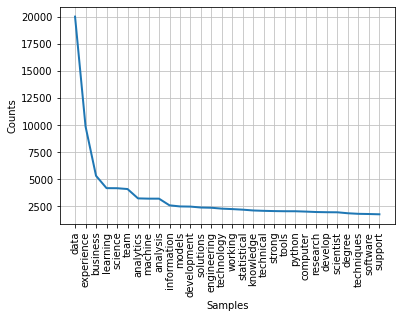

In [84]:
%matplotlib inline
from nltk.probability import FreqDist
plot_freq_dist(word_list_all,num_words=30)

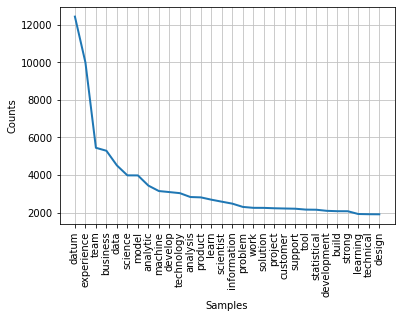

In [85]:
%matplotlib inline
plot_freq_dist(data_lemmatized_all,num_words=30)

In [86]:
# Get the top 20 most common words among all the job descriptions
p_text = data_lemmatized

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

word  frequency
0         datum      12434
1    experience       9995
2          team       5448
3      business       5290
4          data       4509
5       science       3979
6         model       3977
7      analytic       3434
8       machine       3144
9       develop       3089
10   technology       3032
11     analysis       2826
12      product       2807
13        learn       2684
14    scientist       2577
15  information       2473
16      problem       2299
17         work       2250
18     solution       2248
19      project       2227

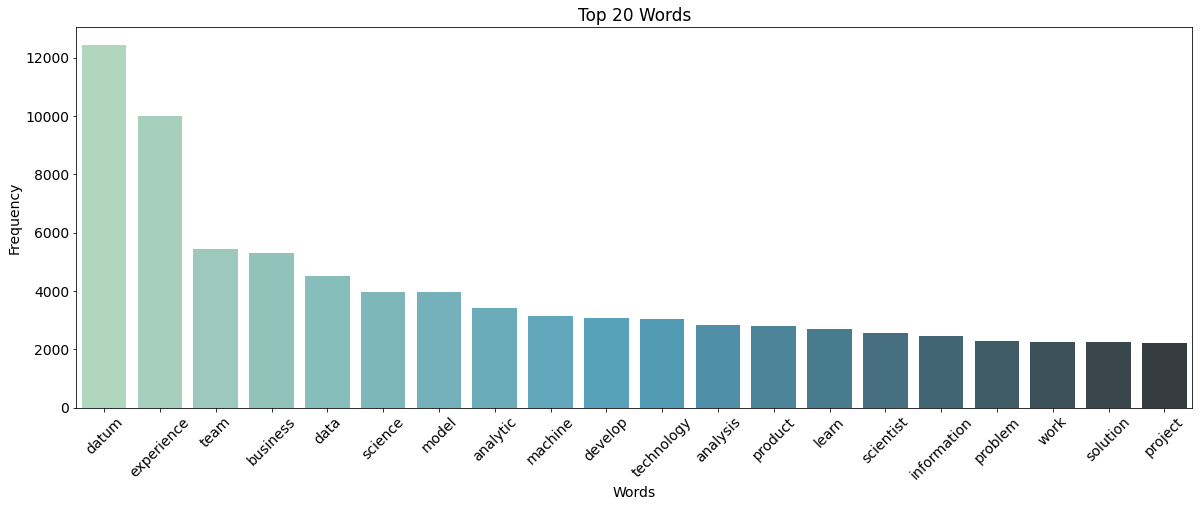

In [87]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)


plt.show()


(-0.5, 999.5, 499.5, -0.5)

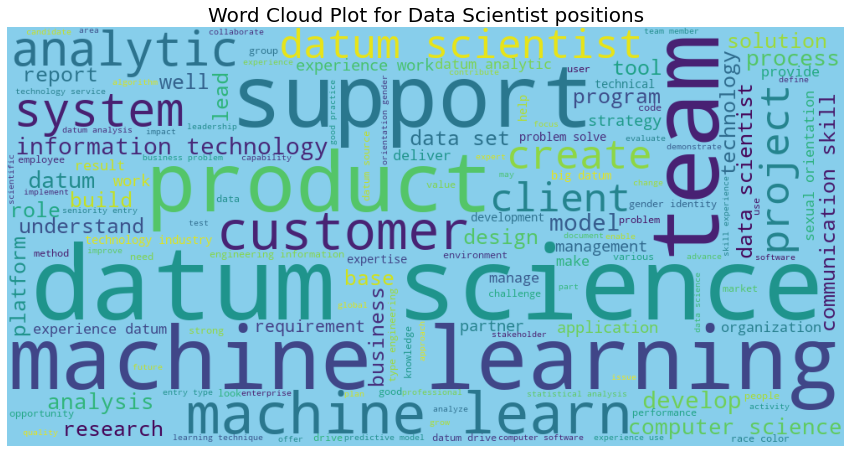

In [39]:
#Code block to generate word cloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
new_list=[]
for listt in data_lemmatized:
  new_list=new_list+listt
  text=" ".join(new_list)

wordcloud = WordCloud(width = 1000, height = 500, 
                background_color ='skyblue', max_words=500, 
                min_font_size = 10).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.title('Word Cloud Plot for Data Scientist positions',size=20)
plt.axis("off")

## Jaccard Similarity & Coherence in LDA-model using Gensim

In [40]:
# Function to calculate Jaccard similarity of two topics
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [ ]:
id2word = corpora.Dictionary(data_lemmatized)
bow_corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# Considering 1-50 topics with 20 keywords each
num_topics = list(range(50)[1:])
num_keywords = 20

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    print(i)
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=id2word,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42
                            )

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [42]:
# Derive mean stability across topics
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [43]:
# Calculate Coherence
coherences = [CoherenceModel(model=LDA_models[i], texts=data_lemmatized, dictionary=id2word, coherence='c_v').get_coherence()\
                for i in num_topics[:-1]]

In [102]:
# Derive the ideal number of topics through the difference between coherence and stability per number of topics
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

In [46]:
# Derive the ideal number of topics through the difference between coherence and stability per number of topics
coh_sta_max = 0
for i in range(num_keywords)[:-1]:
  coh_sta_diffs = coherences[i] - mean_stabilities[i]
  if coh_sta_diffs > coh_sta_max :
    coh_sta_max = coh_sta_diffs
    Jaccard_LDA = mean_stabilities[i]   # Derive the Jaccard Score and Coherence Score for ideal number of topics
    Coherence_LDA = coherences[i]

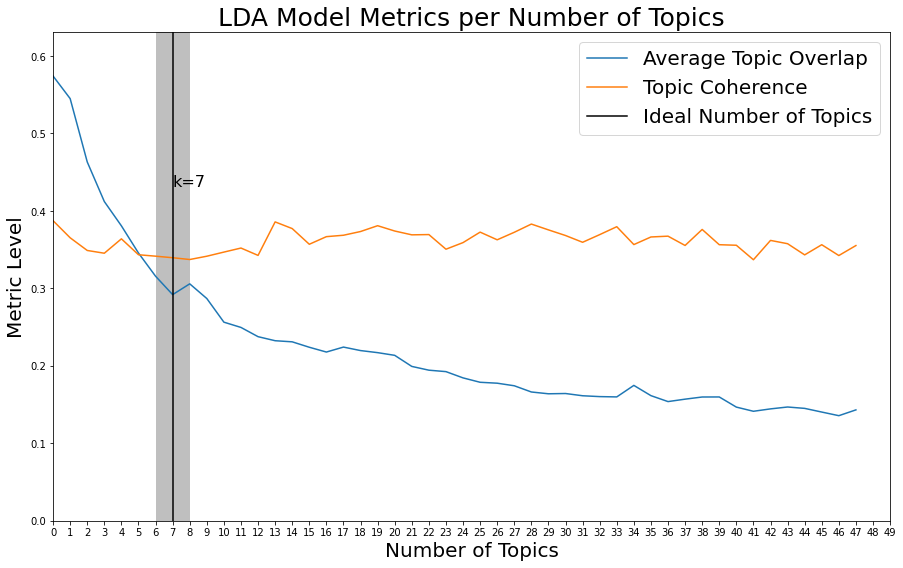

In [101]:
# Generating graphs of Jaccard Similarity, Coherence and Ideal Number of Topics 

plt.figure(figsize=(15,9))
ax = sns.lineplot(x=range(48), y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=range(48), y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
plt.annotate( "k=%d" % ideal_topic_num, xy=(ideal_topic_num, y_max-0.2), fontsize=16)
plt.xticks(range(50))               
ax.axes.set_title('LDA Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [89]:
num_topics = ideal_topic_num
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,id2word=id2word,num_topics=num_topics)
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

[(0,
  '0.018*"datum" + 0.017*"experience" + 0.013*"business" + 0.010*"machine" + '
  '0.009*"science" + 0.008*"team" + 0.007*"analytic" + 0.007*"model" + '
  '0.006*"skill" + 0.006*"develop"'),
 (1,
  '0.023*"datum" + 0.021*"experience" + 0.011*"team" + 0.009*"science" + '
  '0.008*"business" + 0.007*"data" + 0.007*"learn" + 0.006*"develop" + '
  '0.006*"machine" + 0.006*"analytic"'),
 (2,
  '0.025*"datum" + 0.019*"experience" + 0.013*"team" + 0.012*"model" + '
  '0.011*"machine" + 0.009*"learn" + 0.008*"business" + 0.007*"learning" + '
  '0.006*"problem" + 0.006*"science"'),
 (3,
  '0.026*"datum" + 0.019*"experience" + 0.012*"business" + 0.010*"model" + '
  '0.010*"team" + 0.009*"science" + 0.009*"data" + 0.007*"analytic" + '
  '0.007*"analysis" + 0.007*"product"'),
 (4,
  '0.024*"datum" + 0.016*"experience" + 0.010*"business" + 0.010*"team" + '
  '0.007*"machine" + 0.007*"develop" + 0.007*"science" + 0.007*"product" + '
  '0.007*"analytic" + 0.006*"data"'),
 (5,
  '0.019*"datum" + 0

In [104]:
#Compute Perplexity for ideal number of topic solution
Perplexity_LDA = LDA_models[ideal_topic_num].log_perplexity(bow_corpus)  
# a measure of how good the model is. lower the better.
ideal_topic_num_LDA = ideal_topic_num

In [107]:
# Jaccard Similarity,Coherence and Perplexity for ideal no. of topics identified above
print("For best topic solution:",ideal_topic_num, "\nJaccard Similarity Score:",Jaccard_LDA,"\nCoherence Score:",Coherence_LDA,'\nPerplexity:',Perplexity_LDA)

For best topic solution: 7 
Jaccard Similarity Score: 0.21971976274266677 
Coherence Score: 0.3733845903624577 
Perplexity: -7.127077414380341


# LDA BIGRAM

In [111]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import plotly.graph_objects as go
import plotly.express as px
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_jobs['job_description_processed'], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams"))
fig.show()

In [ ]:
# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(data_lemmatized, min_count=20)
data_lemmatized_bigram = data_lemmatized

for idx in range(len(data_lemmatized_bigram)):
    for token in bigram[data_lemmatized[idx]]:
        if '_' in token:
          # Token is a bigram, add to document.
          data_lemmatized_bigram[idx].append(token)


In [ ]:
# Create a dictionary representation of the documents.

#import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized_bigram)

# Filter out words that occur less than 20 documents.
id2word.filter_extremes(no_below=20)

# Bag-of-words representation of the documents.
bow_corpus = [id2word.doc2bow(text) for text in data_lemmatized_bigram]

print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(bow_corpus))



Number of unique tokens: 2696
Number of documents: 2075


In [ ]:
# Considering 1-50 topics with 20 keywords each
num_topics = list(range(50)[1:])
num_keywords = 20

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=id2word,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [ ]:
# Derive mean stability across topics
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [ ]:
# Calculate Coherence
coherences = [CoherenceModel(model=LDA_models[i], texts=data_lemmatized_bigram, dictionary=id2word, coherence='c_v').get_coherence()\
                for i in num_topics[:-1]]

In [ ]:
# Derive the ideal number of topics through the difference between coherence and stability per number of topics

coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

In [ ]:
# Derive the ideal number of topics through the difference between coherence and stability per number of topics
coh_sta_max = 0
for i in range(num_keywords)[:-1]:
  coh_sta_diffs = coherences[i] - mean_stabilities[i]
  if coh_sta_diffs > coh_sta_max :
    coh_sta_max = coh_sta_diffs
    Jaccard_LDA_Bigram = mean_stabilities[i]   # Derive the Jaccard Score and Coherence Score for ideal number of topics
    Coherence_LDA_Bigram = coherences[i]

Perplexity_LDA_Bigram = LDA_models[ideal_topic_num].log_perplexity(bow_corpus)
ideal_topic_num_LDA_Bigram = ideal_topic_num

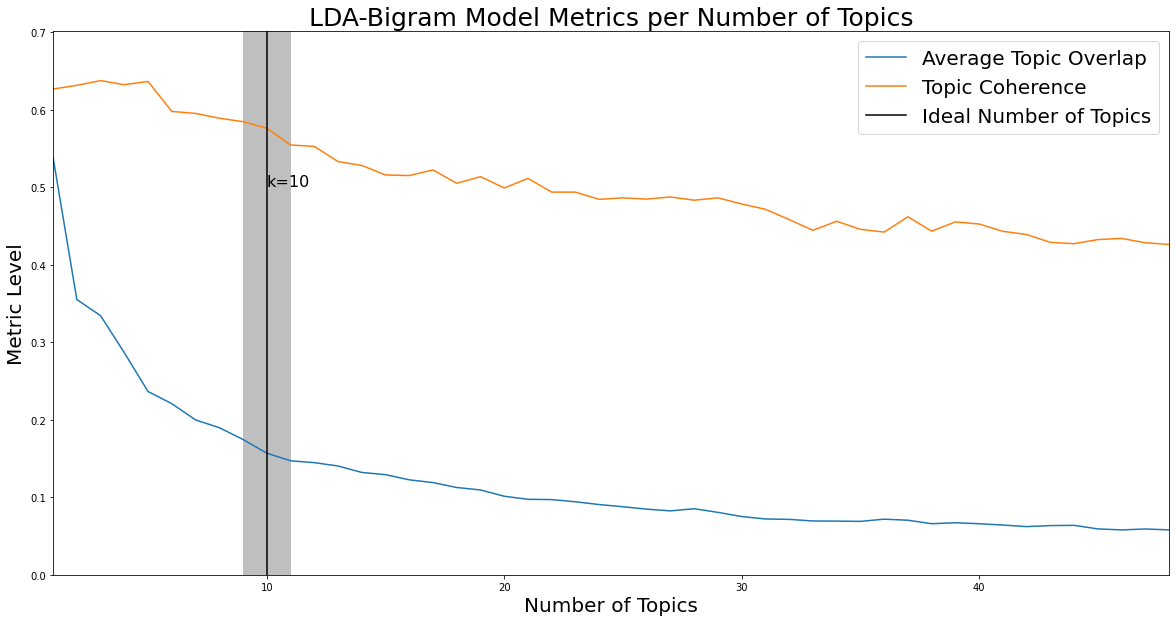

In [ ]:
# Generating graphs of Jaccard Similarity, Coherence and Ideal Number of Topics 

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
plt.annotate( "k=%d" % ideal_topic_num, xy=(ideal_topic_num, y_max-0.2), fontsize=16)

ax.axes.set_title('LDA-Bigram Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [ ]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(LDA_models[ideal_topic_num], bow_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.177090 -0.009738       1        1  15.569112
3      0.138886  0.100234       2        1  12.037956
5      0.015309 -0.146001       3        1  11.890069
2     -0.211714  0.074311       4        1  11.666680
1     -0.000294 -0.089486       5        1   9.015999
9      0.083663  0.021783       6        1   8.884362
8      0.086971 -0.111256       7        1   8.554313
7      0.023809  0.058349       8        1   8.283072
6     -0.054567  0.006111       9        1   7.345867
0      0.095028  0.095694      10        1   6.752569, topic_info=                                    Term          Freq  ...  logprob  loglift
109                     machine_learning  44574.000000  ...  30.0000  30.0000
1107                           big_datum  15032.000000  ...  29.0000  29.0000
842                          team_member   9501.000000  ...  28.0000  28.0000
435                       data_scientist  20678.000000  ...  27.0000  27.0000
308                        machine_learn  37066.000000  ...  26.0000  26.0000
...                                  ...           ...  ...      ...      ...
2225                       non_technical    456.921568  ...  -5.3094   1.0031
308                        machine_learn    728.258557  ...  -4.8433  -1.2346
193   sexual_orientation_gender_identity    436.206628  ...  -5.3558   0.9407
2231                software_development    441.517648  ...  -5.3437   0.0160
936                        solve_problem    439.032407  ...  -5.3494   0.0601

[618 rows x 6 columns], token_table=      Topic      Freq                                    Term
term                                                         
2601      4  0.397817                         access_classify
2601      8  0.119977                         access_classify
2601     10  0.479906                         access_classify
2116      9  0.994823                     access_compensation
2117      9  0.992672  access_compensation_employee_applicant
...     ...       ...                                     ...
1585      6  0.014825        write_verbal_communication_skill
1585      7  0.084501        write_verbal_communication_skill
1585      8  0.072147        write_verbal_communication_skill
1585      9  0.017790        write_verbal_communication_skill
1585     10  0.026190        write_verbal_communication_skill

[3167 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 3, 2, 10, 9, 8, 7, 1])

In [ ]:
#Check if this is needed
num_topics = ideal_topic_num

lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,id2word=id2word,num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

[(0,
  '0.091*"machine_learning" + 0.033*"machine_learn" + '
  '0.018*"data_visualization" + 0.015*"problem_solve" + 0.013*"deep_learning" '
  '+ 0.012*"deep_learn" + 0.012*"team_member" + 0.011*"computer_vision" + '
  '0.011*"good_practice" + 0.010*"natural_language"'),
 (1,
  '0.033*"machine_learning" + 0.027*"machine_learn" + '
  '0.022*"business_intelligence" + 0.022*"data_scientist" + '
  '0.015*"data_visualization" + 0.013*"problem_solve" + 0.012*"data_set" + '
  '0.012*"actionable_insight" + 0.012*"self_starter" + '
  '0.011*"statistical_analysis"'),
 (2,
  '0.038*"machine_learn" + 0.020*"machine_learning" + 0.018*"computer_science" '
  '+ 0.018*"solve_problem" + 0.014*"problem_solve" + 0.013*"big_datum" + '
  '0.012*"artificial_intelligence" + 0.012*"data_set" + '
  '0.011*"ideal_candidate" + 0.011*"data_scientist"'),
 (3,
  '0.045*"machine_learning" + 0.035*"machine_learn" + 0.025*"computer_science" '
  '+ 0.013*"neural_network" + 0.013*"data_set" + 0.012*"master_degree" + '
 

In [ ]:
ideal_topic_num_LDA_Bigram = ideal_topic_num

#Compute Perplexity for ideal number of topic solution. A measure of how good the model is; lower the better.
Perplexity_LDA_Bigram = LDA_models[ideal_topic_num].log_perplexity(bow_corpus)

In [ ]:
# Jaccard Similarity,Coherence and Perplexity for ideal no. of topics identified above
print("For best topic solution:",ideal_topic_num_LDA_Bigram, "\nJaccard Similarity Score:",Jaccard_LDA_Bigram,"\nCoherence Score:",Coherence_LDA_Bigram,'\nPerplexity:',Perplexity_LDA_Bigram)

For best topic solution: 10 
Jaccard Similarity Score: 0.1569230821974528 
Coherence Score: 0.5761303346769806 
Perplexity: -6.286582353778117


#GENSIM NMF

In [112]:
num_topics = list(range(50)[1:])
num_keywords = 20

coherence_scores = []
id2word = corpora.Dictionary(data_lemmatized)

# Filter out extremes to limit the number of features
id2word.filter_extremes(no_below=0.1, keep_n=5000)

# Create the bag-of-words format (list of (token_id, token_count))
bow_corpus = [id2word.doc2bow(text) for text in data_lemmatized]

nmf_models = {}
nmf_topics = {}
for i in num_topics:
    nmf_models[i] = Nmf(
      corpus=bow_corpus,
      num_topics=i,
      id2word=id2word,
      chunksize=2000,
      passes=20,
      kappa=.1,
      minimum_probability=0.01,
      w_max_iter=300,
      w_stop_condition=0.0001,
      h_max_iter=100,
      h_stop_condition=0.001,
      eval_every=1,
      normalize=True
  )
    shown_topics_nmf = nmf_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    nmf_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics_nmf]
    
# Derive mean stability across topics
NMF_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(nmf_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(nmf_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    NMF_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities_NMF = [np.array(NMF_stability[i]).mean() for i in num_topics[:-1]]

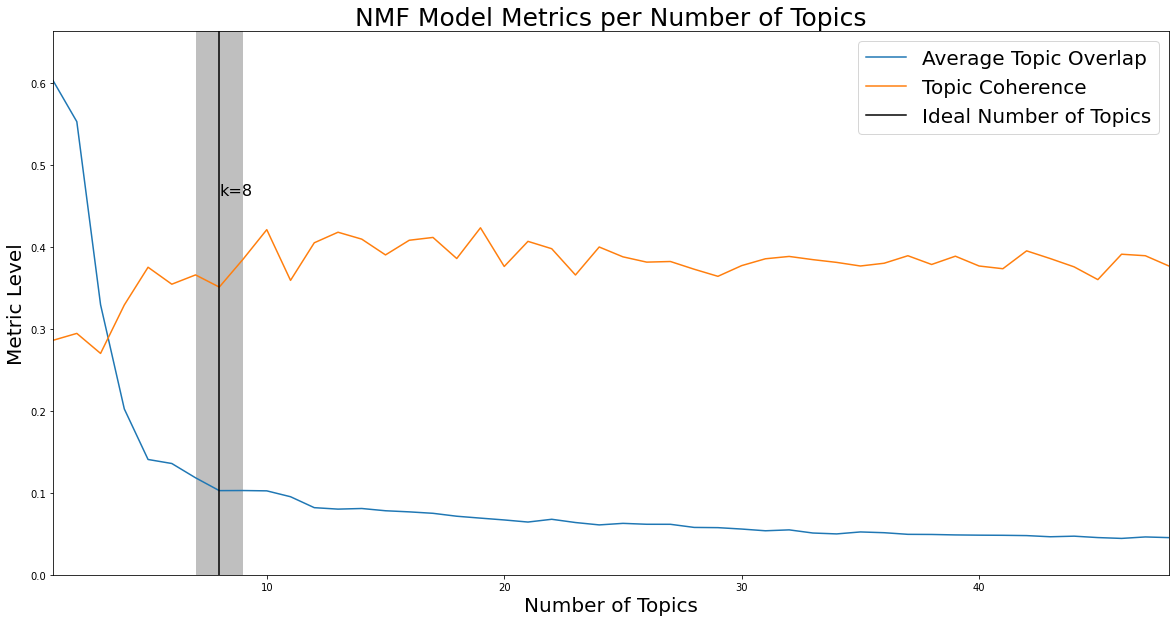

In [113]:
# Calculate Coherence
coherences_nmf = [CoherenceModel(model=nmf_models[i], texts=data_lemmatized, dictionary=id2word, coherence='c_v').get_coherence()\
                for i in num_topics[:-1]]

# Derive the ideal number of topics through the difference between coherence and stability per number of topics

coh_sta_diffs_NMF = [coherences_nmf[i] - mean_stabilities_NMF[i] for i in range(8)] # limit topic numbers to the number of keywords
coh_sta_max_NMF = max(coh_sta_diffs_NMF)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs_NMF) if j == coh_sta_max_NMF]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num_NMF = num_topics[ideal_topic_num_index]

# Generating graphs of Jaccard Similarity, Coherence and Ideal Number of Topics 

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities_NMF, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences_nmf, label='Topic Coherence')

ax.axvline(x=ideal_topic_num_NMF, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num_NMF - 1, xmax=ideal_topic_num_NMF + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities_NMF), max(coherences_nmf)) + (0.10 * max(max(mean_stabilities_NMF), max(coherences_nmf)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])

plt.annotate( "k=%d" % ideal_topic_num_NMF, xy=(ideal_topic_num_NMF, y_max-0.2), fontsize=16)
                
ax.axes.set_title('NMF Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [114]:
# Taking a look at the topics of the best model suggested by the previous graph
from pprint import pprint
pprint(nmf_models[ideal_topic_num_NMF].print_topics(20))


[(0,
  '0.054*"customer" + 0.017*"help" + 0.015*"marketing" + 0.013*"drive" + '
  '0.011*"understand" + 0.010*"insight" + 0.010*"deliver" + 0.009*"improve" + '
  '0.009*"role" + 0.008*"make"'),
 (1,
  '0.024*"research" + 0.024*"technical" + 0.019*"technique" + 0.013*"apply" + '
  '0.013*"knowledge" + 0.011*"relate" + 0.010*"demonstrate" + 0.010*"large" + '
  '0.010*"language" + 0.010*"customer"'),
 (2,
  '0.019*"analytical" + 0.019*"process" + 0.016*"technical" + 0.012*"program" '
  '+ 0.011*"knowledge" + 0.010*"employee" + 0.009*"lead" + 0.008*"result" + '
  '0.008*"clinical" + 0.008*"plan"'),
 (3,
  '0.010*"large" + 0.009*"service" + 0.009*"insight" + 0.009*"solve" + '
  '0.009*"good" + 0.009*"world" + 0.009*"gender" + 0.008*"drive" + '
  '0.008*"create" + 0.008*"learning"'),
 (4,
  '0.020*"process" + 0.019*"report" + 0.016*"database" + 0.016*"system" + '
  '0.015*"requirement" + 0.013*"management" + 0.010*"knowledge" + '
  '0.009*"issue" + 0.009*"analyze" + 0.009*"analyst"'),
 (5,
 

In [115]:
# Derive the ideal number of topics through the difference between coherence and stability per number of topics
ideal_topic_num_NMF
coh_sta_max_NMF = 0
b=0
for i in range(num_keywords)[:-1]:
  coh_sta_diffs_nmf = coherences_nmf[i] - mean_stabilities_NMF[i]
  if coh_sta_diffs_nmf > coh_sta_max_NMF :         
    coh_sta_max_NMF = coh_sta_diffs_nmf
    Jaccard_NMF = mean_stabilities_NMF[i]   # Derive the Jaccard Score and Coherence Score for ideal number of topics
    Coherence_NMF = coherences_nmf[i]

In [116]:
# Jaccard Similarity,Coherence and Perplexity for ideal no. of topics identified above
print("For best topic solution:",ideal_topic_num_NMF, "\nJaccard Similarity Score:",Jaccard_NMF,"\nCoherence Score:",Coherence_NMF)

For best topic solution: 8 
Jaccard Similarity Score: 0.06909960615036757 
Coherence Score: 0.42311158279259703


### BTM ##

In [131]:
texts = df_jobs['job_description_processed'].str.strip().tolist()
# new_list=[]
# for listt in data_lemmatized:
#   new_list=new_list+listt
#   texts=" ".join(new_list)

In [132]:
# PREPROCESSING
# Obtaining terms frequency in a sparse matrix and corpus vocabulary
X, vocabulary, vocab_dict = btm.get_words_freqs(texts, stop_words=stop_words)
tf = np.array(X.sum(axis=0)).ravel()
# Vectorizing documents
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
docs_lens = list(map(len, docs_vec))
# Generating biterms
biterms = btm.get_biterms(docs_vec)

In [ ]:
# INITIALIZING AND RUNNING MODEL

# Considering 50 topics
num_topics = list(range(50)[1:])
num_keywords = 20

btm_models = {}
perplexity_list =[]
coherence_list = []
for i in num_topics:
    btm_models[i] = btm.BTM(X, vocabulary, seed=12345, T=i, M=num_keywords)
    btm_models[i].fit(biterms, iterations=20)
    p_zd = btm_models[i].transform(docs_vec)
    perplexity = btm.perplexity(btm_models[i].matrix_topics_words_, p_zd, X, i)
    coherence = btm.coherence(btm_models[i].matrix_topics_words_, X, M=20)
    perplexity_list.append(perplexity)
    coherence_list.append(coherence)


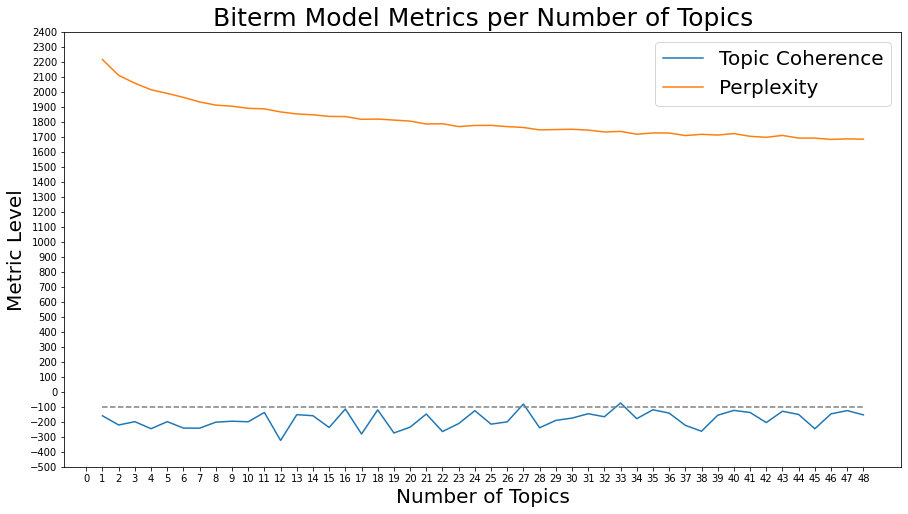

In [ ]:
# show graph
plt.figure(figsize=(15,8))

ax = sns.lineplot(x=num_topics[:-1], y=coherence_list[:-1][-1], label='Topic Coherence')
ax = sns.lineplot(x=num_topics[:-1], y=perplexity_list[:-1][:], label='Perplexity')
ax = sns.lineplot(x=num_topics[:-1], y=-100,linestyle='--', color='grey')

ax.axes.set_title('Biterm Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
ax.set_xticks(range(len(num_topics)))
ax.set_yticks(range(-500,2500,100))
plt.legend(fontsize=20)
plt.show()   


In [136]:
best_k = 16
perplexity_BTM = btm.perplexity(btm_models[best_k].matrix_topics_words_, p_zd, X, best_k)
coherence_BTM = ymax
print(best_k,coherence_BTM,perplexity_BTM)

16 -95.03123574908521 8185.0369385386775


In [137]:
p_zd = btm_models[best_k].transform(docs_vec)

100%|██████████| 2075/2075 [00:01<00:00, 1625.47it/s]


In [138]:
phi = tmp.get_phi(btm_models[best_k])
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=0, lambda_=1)
tmp.plot_terms(terms_probs)

alt.Chart(...)

In [139]:
tmp.report(model=btm_models[best_k], docs=texts)

##### The terms in topic 12 are some of the most relevant skills for Data Scientist - Python, SQL, deep learning, machine learning, cloud, Spark, Hadoop, big data, AWS, Visualization.

## Compare the models

In [128]:
data = {'Algorithm':['LDA', 'LDA Bigram','NMF', 'BTM'],
        'Ideal No. of Topics':[ideal_topic_num_LDA,ideal_topic_num_LDA_Bigram,ideal_topic_num_NMF,ideal_topic_num_BTM ],
        'Jaccard Similarity':[Jaccard_LDA,Jaccard_LDA_Bigram,Jaccard_NMF,''],
        'Coherence':[Coherence_LDA,Coherence_LDA_Bigram,Coherence_NMF,coherence_BTM],
        'Perplexity':[Perplexity_LDA,Perplexity_LDA_Bigram,'',perplexity_BTM]  
       }
# Create DataFrame
df = pd.DataFrame(data)
  
# Print the output.
df

Algorithm  Ideal No. of Topics Jaccard Similarity  Coherence Perplexity
0         LDA                    7            0.21972   0.373385   -7.12708
1  LDA Bigram                   10           0.156923   0.576130   -6.28658
2         NMF                    8          0.0690996   0.423112           
3         BTM                   16                    -95.031236    8185.04

###*Assessed the keywords under each topic for best topic solution of each model. The topics for LDA Bigram and NMF were most relevant. As my dataset is the job descriptions of only Data Scientist positions, topic solutions 8 or 10 seem be better to go with.*
### Run the best model (sklearn nmf) for the best topic solution (K=8)

In [ ]:
# Noun extract and lemmatize function

def nouns(text):
    #Given a string of text, tokenize the text 
    #and pull out only the nouns.   
    
    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == 'NN'    
    
    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)    
    
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()    
    
    # use list comprehension to lemmatize all words 
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    
    #return string of joined list of nouns
    return ' '.join(all_nouns)

# Create dataframe of only nouns from speeches
data_nouns = pd.DataFrame(df_jobs.Description.apply(nouns)) 

# Visually Inspect
data_nouns.head()



In [58]:
from sklearn.feature_extraction import text

# Add additional stop words since we are recreating the document-term matrix
stop_noun = ['full','use','service','time','level','present','end','way','focus','set','internal','work','status','base','day','origin','need','protect','variety','opportunity','source','background','member','identify','level','relevant','employer','key','requirement','preferred','solution','employment','function','complex','field','relate','also','general','take','applicant','standard','prefer','provide','perform','need','skill','base','application','datum','able','ability','new','must','provide','ensure','from', 'subject', 're', 'edu', 'use','require','seeking','position','years','job','including','required','opportunity','work','job','description','apply','needed','company','join','meet','area','order','look','include','contact','bring','direct','null']
stop_words_noun_agg = text.ENGLISH_STOP_WORDS.union(stop_noun)

In [59]:
# Store TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words = stop_words_noun_agg, 
                             ngram_range = (1,1), 
                             max_df = 0.85, 
                             min_df = 0.01)

# Fit and Transform speech noun text to a TF-IDF Doc-Term Matrix
data_vectorizer = vectorizer.fit_transform(data_nouns.Description)
# Create data-frame of Doc-Term Matrix with nouns as column names
data_vectorized = pd.DataFrame(data_vectorizer.toarray(), columns = vectorizer.get_feature_names())
data_vectorized.index = data_nouns.index

In [60]:
def display_topics(model, feature_names, num_top_words,topic_names=None):
#'''Given an NMF model, feature_names, and number of top words, print topic number 
#and its top feature names, up to specified number of top words.'''    
    
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, topic in enumerate(model.components_):        
        
        #print topic, topic number, and top words
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]
def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = ("topic_%d:" % topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

In [61]:
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok.lower() in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok.lower() )
            yield tokens
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            #print(str(pair[0]) + " " + str(pair[1]))
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms


In [118]:
# Now run the sklearn nmf model for the best topic solution

best_num_topics = 8
# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(data_vectorizer)

In [119]:
doc_topic = nmf.fit_transform(data_vectorized)
display_topics(nmf, vectorizer.get_feature_names(), 20)


Topic  0
business, analytics, model, analysis, insight, customer, modeling, decision, technique, stakeholder, analyst, tool, marketing, partner, recommendation, management, strategy, visualization, organization, process

Topic  1
machine, learning, model, ml, science, ai, algorithm, technique, computer, research, problem, tensorflow, nlp, python, language, processing, team, deep, engineering, production

Topic  2
employee, gender, disability, law, race, religion, veteran, color, orientation, information, identity, age, sex, regard, accommodation, government, security, individual, pay, citizenship

Topic  3
xa0, industries, seniority, information, technology, contract, scientist, services, business, science, type, analyst, atlanta, health, edge, nlp, model, investment, com, world

Topic  4
product, team, customer, people, world, engineering, science, role, insight, marketing, scientist, problem, growth, technology, user, platform, engineer, impact, success, decision

Topic  5
health, r

##Assigning topic number to each job description



In [66]:
def remove_stopwordss(tokens):
    words = []
    for token in tokens:
        if len(token) > 1:
            if token not in stop_words:
                words.append(token)
    return words
    
def lemmatize(tokens, allowed_postags=['NN', 'JJ', 'VBG', 'RB']):
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens_out = []
    for token in tokens:
        lemma = wordnet_lemmatizer.lemmatize(token)
        if nltk.pos_tag([lemma])[0][1] in allowed_postags:
            tokens_out.append(lemma)
    return tokens_out

In [67]:
df_final = pd.DataFrame(df_jobs['job_description_processed'])
df_final.job_description_processed = df_final.job_description_processed.replace('\n', " ")
df_final.job_description_processed =  df_final.job_description_processed.replace("[^a-zA-Z]+", " ", regex = True)
df_final["tokens"] = df_final.job_description_processed.apply(word_tokenize)
df_final["tokens_stopwords_removed"] = df_final.tokens.apply(remove_stopwordss)
df_final["lemmatized"] = df_final.tokens_stopwords_removed.apply(lemmatize)
df_final["lemmatized_text"] = df_final.lemmatized.apply(' '.join)
df_final.lemmatized = df_final.lemmatized_text.astype(str).apply(lambda x: x.split(' '))
df_final = df_final.drop(['tokens', 'tokens_stopwords_removed'], axis=1)
df_final.head(10)

job_description_processed  ...                                    lemmatized_text
0  auto req id br job description bring your pass...  ...  auto req id br job description bring passion t...
1  now brewing data scientist operations analytic...  ...  brewing scientist operation tobeapartner begin...
2  who we are fueled by a fundamental belief that...  ...  fundamental belief access financial service op...
3  abbott is a global healthcare leader that help...  ...  abbott global healthcare leader help live full...
4  who is mastercard we are the global technology...  ...  mastercard global technology company world pay...
5  at lyft our mission is to improve people s liv...  ...  lyft mission life world transportation start c...
6  firm overview job description blackstone is on...  ...  firm overview job description blackstone world...
7  warnermedia is a leading media and entertainme...  ...  warnermedia leading medium entertainment compa...
8  posted by kit evans kit evans recruiter at str...  ...  kit kit recruiter stripe stripe software platf...
9   abbvie nyse abbv is a global research based b...  ...  abbvie nyse abbv global research biopharmaceut...

[10 rows x 3 columns]

In [68]:
topics_desciptions = pd.concat([df_final, pd.DataFrame(doc_topic)], axis=1)
topics_desciptions['Max'] = topics_desciptions.iloc[:, np.r_[3:10]].idxmax(axis=1)
topics_desciptions.head(5)

job_description_processed  ...  Max
0  auto req id br job description bring your pass...  ...  2.0
1  now brewing data scientist operations analytic...  ...  0.0
2  who we are fueled by a fundamental belief that...  ...  2.0
3  abbott is a global healthcare leader that help...  ...  5.0
4  who is mastercard we are the global technology...  ...  2.0

[5 rows x 11 columns]

In [69]:
dominant_descriptions = pd.DataFrame(topics_desciptions)
pd.DataFrame(topics_desciptions[topics_desciptions['Max']==1.0]['job_description_processed'])

job_description_processed
22    the candidate should have the following skills...
25     janssen pharmaceuticals inc a member of johns...
29    posted by francois xavier hussherr phd francoi...
30    posted by sherry jordan sherry jordan hka ente...
39    summary data scientist works directly with a t...
...                                                 ...
2057  data analyst medical economics team a privatel...
2060  artificial intelligence scientist to be based ...
2066  bachelor s degree years of experience with dat...
2068  responsibilities noblis and our wholly owned s...
2074  who we are avibra is an end to end consumer lo...

[536 rows x 1 columns]

In [70]:
# Export the DataFrame to csv
topics_desciptions.to_csv('topics_desciptions.csv')
!cp topics_desciptions.csv "/drive/My Drive/Colab Notebooks/"